# `nova` Window Limit Experiment Analysis

## Overview

This notebook analyzes the results of testing different `--max-reads-per-window` parameter values in Nova, a de novo variant insertion simulator. The experiment compares 1, 3, and 10 reads per genomic window to understand how this parameter affects false positive rates and genomic clustering.

## Background

Nova simulates ultra-low frequency structural variant insertions in long-read sequencing data. During development, we discovered that the original read selection strategy was causing **genomic clustering** - multiple nova reads from the same genomic region being clustered together by variant callers like Sniffles, resulting in false positives.

## Problem Statement

The original Nova implementation showed >100% detection rates, indicating false positives. Investigation revealed that Nova was selecting multiple reads from overlapping genomic windows, causing variant callers to cluster these artificial insertions together.

## Solution Implementation

We implemented a `--max-reads-per-window` parameter in Nova to limit the number of reads selected from each genomic window:

- **Source code**: `src/nova/read_selector.py` - `_select_reads_unified()` method
- **CLI interface**: `src/nova/cli.py` - Added `--max-reads-per-window` option
- **Analysis scripts**: 
  - `scripts/analyze_vcf_results.py` - Variant detection analysis
  - `scripts/analyze_false_positives.py` - False positive categorization

## Experimental Design

We conducted three controlled experiments:
1. **1 read per window** - True de novo simulation (our proposed fix)
2. **3 reads per window** - Moderate clustering allowed
3. **10 reads per window** - High clustering allowed (similar to original behavior)

Each experiment used identical configurations (1,000 insertions total) with the same input BAM file.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

# Define color scheme for consistent plotting
COLORS = {
    '1_read': '#2E8B57',  # Sea Green
    '3_reads': '#4682B4',  # Steel Blue  
    '10_reads': '#CD5C5C'  # Indian Red
}

print("Libraries imported successfully!")
print(f"Analysis timestamp: {pd.Timestamp.now()}")

Libraries imported successfully!
Analysis timestamp: 2025-06-29 14:45:15.177269


## Data Loading and Preprocessing

Loading experimental data from all three window limit configurations:

In [13]:
# Define data directories
data_dirs = {
    '1_read': Path('../archive/one_read_per_window'),
    '3_reads': Path('../archive/three_reads_per_window'), 
    '10_reads': Path('../archive/ten_reads_per_window')
}

# Load variant analysis data
variant_data = {}
for condition, path in data_dirs.items():
    csv_file = path / 'nova_variant_analysis_tabular.csv'
    if csv_file.exists():
        variant_data[condition] = pd.read_csv(csv_file)
        print(f"Loaded {len(variant_data[condition])} variants for {condition} condition")
    else:
        print(f"Warning: {csv_file} not found")

# Load false positive analysis data
fp_data = {}
for condition, path in data_dirs.items():
    json_file = path / 'false_positives_analysis.json'
    if json_file.exists():
        with open(json_file, 'r') as f:
            fp_data[condition] = json.load(f)
        print(f"Loaded {fp_data[condition]['metadata']['total_false_positives']} false positives for {condition} condition")
    else:
        print(f"Warning: {json_file} not found")

# Load simulation statistics
stats_data = {}
for condition, path in data_dirs.items():
    json_file = path / 'nova_statistics.json'
    if json_file.exists():
        with open(json_file, 'r') as f:
            stats_data[condition] = json.load(f)
        print(f"Loaded simulation statistics for {condition} condition")
    else:
        print(f"Warning: {json_file} not found")

print("\nData loading complete!")

Loaded 1086 variants for 1_read condition
Loaded 1084 variants for 3_reads condition
Loaded 1111 variants for 10_reads condition
Loaded 107 false positives for 1_read condition
Loaded 74 false positives for 3_reads condition
Loaded 119 false positives for 10_reads condition
Loaded simulation statistics for 1_read condition
Loaded simulation statistics for 3_reads condition
Loaded simulation statistics for 10_reads condition

Data loading complete!


In [14]:
# Create summary statistics table
summary_stats = []

for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data and condition in fp_data:
        vdata = variant_data[condition]
        fpdata = fp_data[condition]
        
        # Calculate key metrics
        total_variants = len(vdata)
        single_nova_calls = len(vdata[vdata['is_single_read_call'] == True])
        false_positives = fpdata['metadata']['total_false_positives']
        
        # Genomic clustering from false positive analysis
        clustering_count = fpdata['summary_statistics']['pattern_statistics'].get('variants_with_genomic_clustering', 0)
        clustering_pct = (clustering_count / false_positives * 100) if false_positives > 0 else 0
        
        summary_stats.append({
            'Condition': condition.replace('_', ' ').title(),
            'Total Variants': total_variants,
            'Single Nova Calls': single_nova_calls,
            'Single Nova %': f"{single_nova_calls/total_variants*100:.1f}%",
            'False Positives': false_positives,
            'Genomic Clustering': clustering_count,
            'Clustering %': f"{clustering_pct:.1f}%"
        })

summary_df = pd.DataFrame(summary_stats)
print("Experiment Summary:")
print(summary_df.to_string(index=False))

Experiment Summary:
Condition  Total Variants  Single Nova Calls Single Nova %  False Positives  Genomic Clustering Clustering %
   1 Read            1086                979         90.1%              107                   0         0.0%
  3 Reads            1084                930         85.8%               74                  59        79.7%
 10 Reads            1111                798         71.8%              119                 107        89.9%


## True Positive Analysis

**True Positive Rate** - here, the percentage of simulated insertions that resulted in clean, single nova-only variant calls. Technically, we calculate this as **equivalent to recall**. For true de novo simulation, each insertion should result in exactly one clean variant call. Rates >100% indicate clustering artifacts, not better performance.

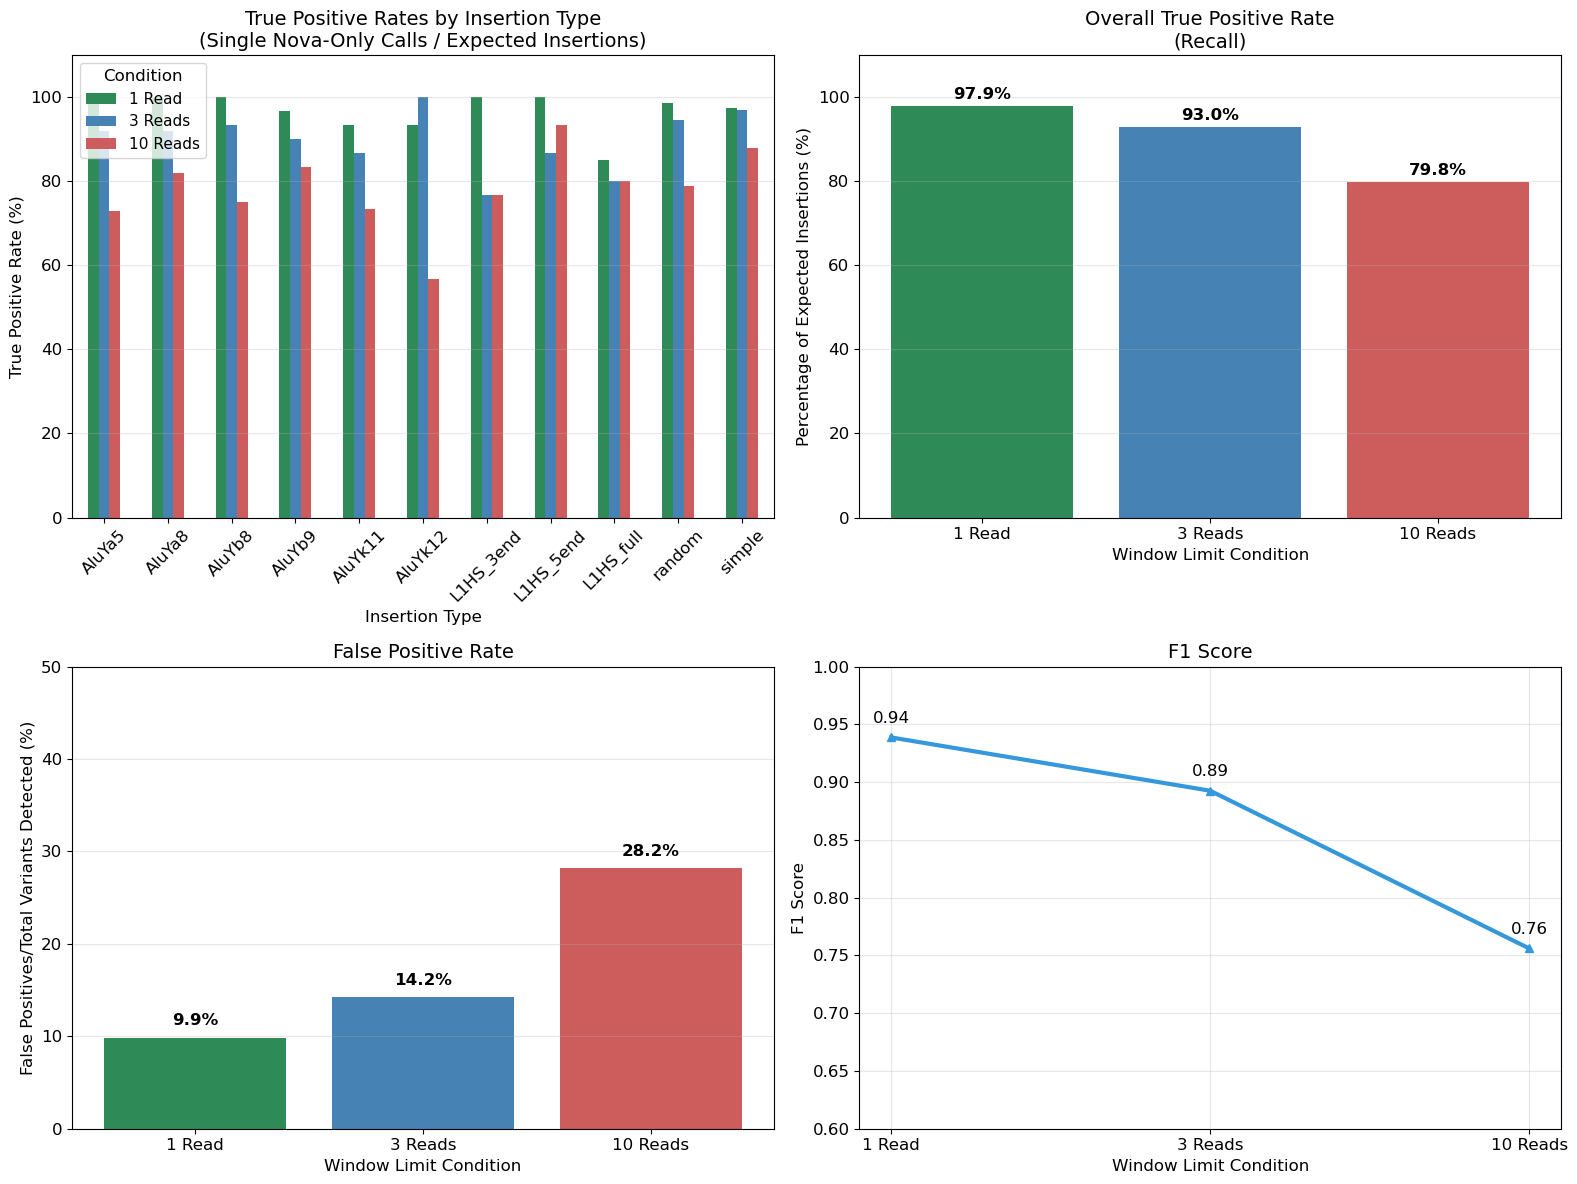

In [53]:
# Calculate TRUE POSITIVE RATES by insertion type
true_positive_rates = []

for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        
        # Expected counts (from simulation configuration)
        expected = {
            'random': 400, 'simple': 200, 'AluYa5': 100, 'AluYb8': 60, 'AluYa8': 50,
            'AluYb9': 30, 'AluYk11': 30, 'AluYk12': 30, 'L1HS_5end': 30, 'L1HS_3end': 30, 'L1HS_full': 40
        }
        
        for insertion_type, expected_count in expected.items():
            # Count SINGLE NOVA-ONLY calls (true positives) for this type
            type_data = vdata[vdata['insertion_type'] == insertion_type]
            single_nova_calls = len(type_data[
                (type_data['is_single_read_call'] == True) & 
                (type_data['nova_reads'] == 1)
            ])
            
            # Calculate true positive rate and read utilization
            true_positive_rate = (single_nova_calls / expected_count) * 100
            total_detected = len(type_data)  # All variants detected (including false positives)
            detection_quality = (single_nova_calls / total_detected * 100) if total_detected > 0 else 0
            
            true_positive_rates.append({
                'Condition': condition.replace('_', ' ').title(),
                'Insertion Type': insertion_type,
                'Expected': expected_count,
                'Single Nova Calls': single_nova_calls,
                'Total Detected': total_detected,
                'True Positive Rate': true_positive_rate,
                'Detection Quality': detection_quality
            })

tp_df = pd.DataFrame(true_positive_rates)

# Create visualization with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: True Positive Rates by insertion type
pivot_tp = tp_df.pivot(index='Insertion Type', columns='Condition', values='True Positive Rate')
pivot_tp = pivot_tp[['1 Read', '3 Reads', '10 Reads']]  # Set column order
pivot_tp.plot(kind='bar', ax=ax1, color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']], legend=True)
ax1.set_title('True Positive Rates by Insertion Type\n(Single Nova-Only Calls / Expected Insertions)')
ax1.set_ylabel('True Positive Rate (%)')
ax1.set_xlabel('Insertion Type')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 110)

# Plot 2: Overall True Positive Rates
overall_tp_rates = tp_df.groupby('Condition').apply(
    lambda x: (x['Single Nova Calls'].sum() / x['Expected'].sum()) * 100
).reset_index(name='Overall True Positive Rate')
overall_tp_rates = overall_tp_rates.sort_values('Condition', key=lambda x: pd.Categorical(x, ['1 Read', '3 Reads', '10 Reads']))

bars = ax2.bar(overall_tp_rates['Condition'], overall_tp_rates['Overall True Positive Rate'], 
              color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax2.set_title('Overall True Positive Rate\n(Recall)')
ax2.set_ylabel('Percentage of Expected Insertions (%)')
ax2.set_xlabel('Window Limit Condition')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 110)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: False Positives (what fraction of detected variants were false positives)
overall_quality = tp_df.groupby('Condition').apply(
    lambda x: (1 - (x['Single Nova Calls'].sum() / x['Total Detected'].sum())) * 100
).reset_index(name='False Positives')
overall_quality = overall_quality.sort_values('Condition', key=lambda x: pd.Categorical(x, ['1 Read', '3 Reads', '10 Reads']))

bars3 = ax3.bar(overall_quality['Condition'], overall_quality['False Positives'], 
               color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax3.set_title('False Positive Rate')
ax3.set_ylabel('False Positives/Total Variants Detected (%)')
ax3.set_xlabel('Window Limit Condition')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, 50)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 4: F1 Score
metrics = []
for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        # Calculate precision and recall
        true_positives = len(vdata[(vdata['is_single_read_call'] == True) & (vdata['nova_reads'] == 1)])
        total_detected = len(vdata)
        total_expected = 1000  # Total expected insertions
        
        precision = true_positives / total_detected if total_detected > 0 else 0
        recall = true_positives / total_expected
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics.append({
            'Condition': condition.replace('_', ' ').title(),
            'F1': f1
        })

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values('Condition', key=lambda x: pd.Categorical(x, ['1 Read', '3 Reads', '10 Reads']))

# Plot F1 score
ax4.plot(metrics_df['Condition'], metrics_df['F1'], '^-', color='#3498db', linewidth=3)

# Add value labels
for i, row in metrics_df.iterrows():
    ax4.text(i, row['F1'] + 0.01, f'{row["F1"]:.2f}', ha='center', va='bottom')

ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score')
ax4.set_xlabel('Window Limit Condition')
ax4.grid(True, alpha=0.3)

# Set y-axis limits
ax4.set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()

- **1 read/window**: 97.9% true positive rate (979/1000 clean detections)
- **3 reads/window**: 93.0% true positive rate (930/1000 clean detections)  
- **10 reads/window**: 79.8% true positive rate (798/1000 clean detections)

This demonstrates that **lower window limits achieve better de novo simulation performance** (see next section on false positives and genomic clustering).

## False Positive Analysis

Summary: Genomic clustering increases dramatically with the # of max reads per window.

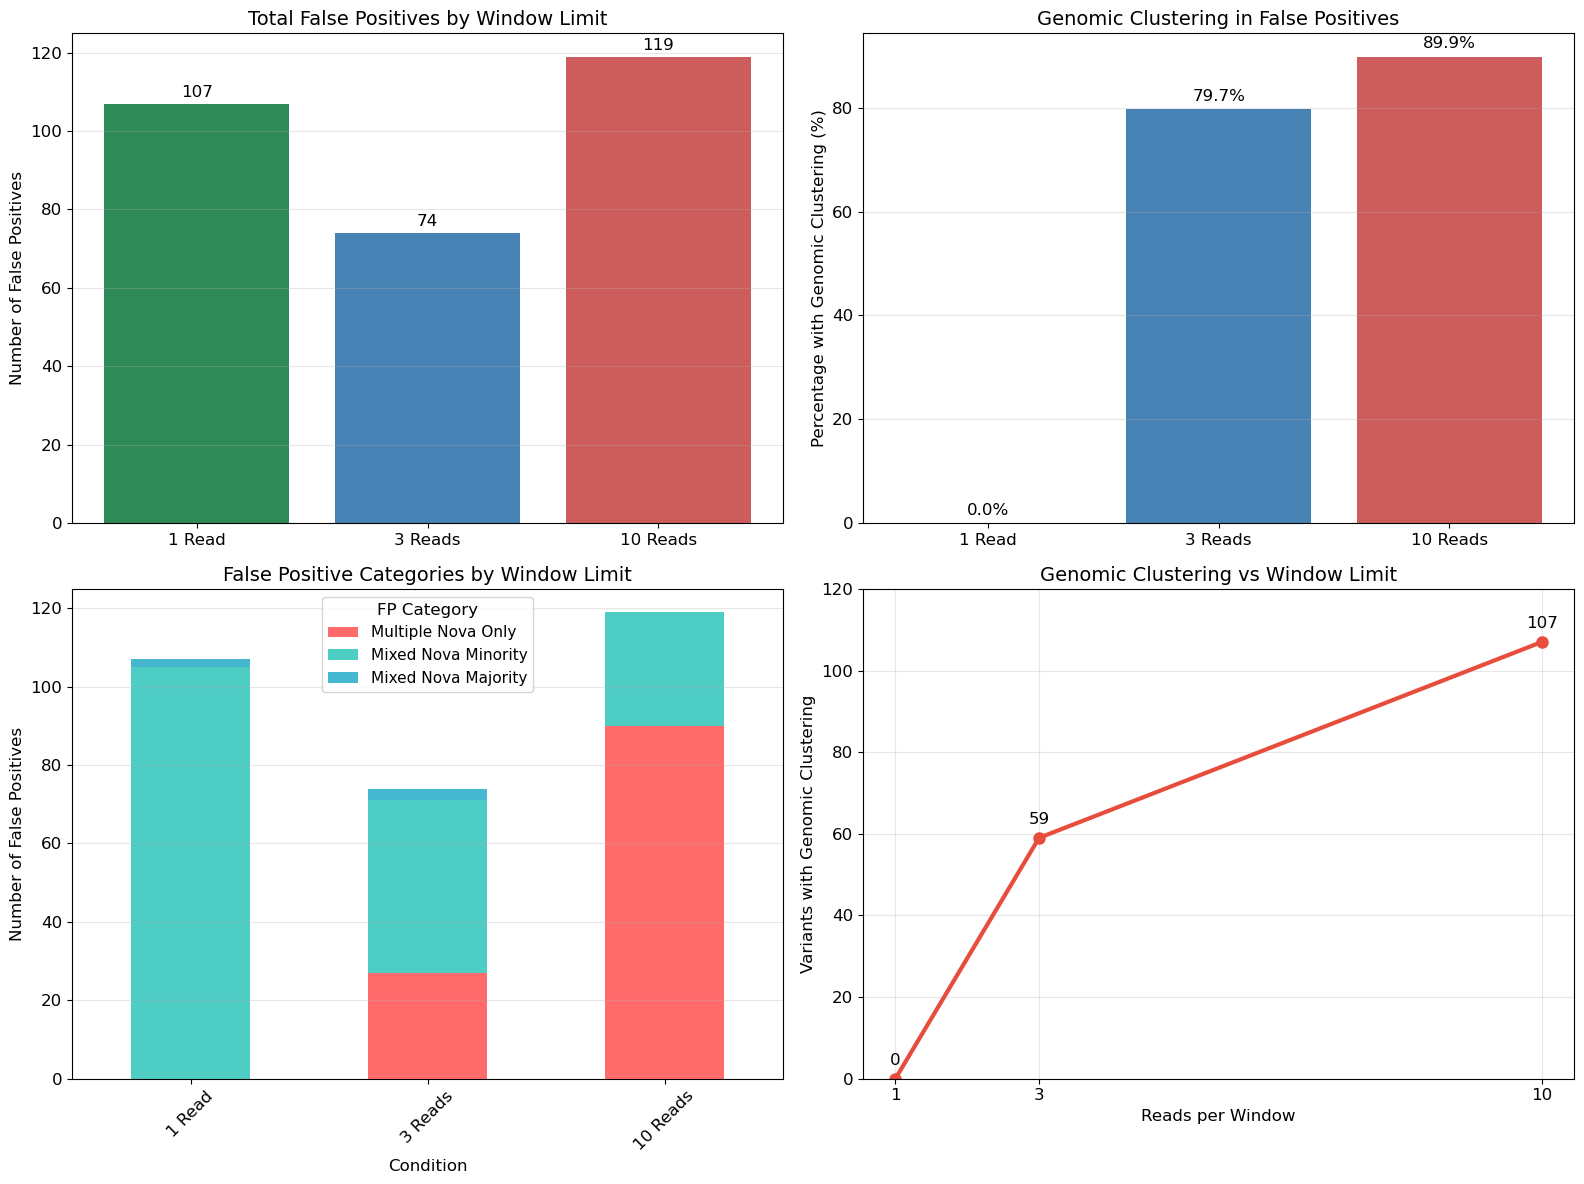

In [16]:
# Prepare false positive data for visualization
fp_summary = []

for condition in ['1_read', '3_reads', '10_reads']:
    if condition in fp_data:
        fpdata = fp_data[condition]
        total_fp = fpdata['metadata']['total_false_positives']
        clustering = fpdata['summary_statistics']['pattern_statistics'].get('variants_with_genomic_clustering', 0)
        
        # Category breakdown
        categories = fpdata['summary_statistics']['category_breakdown']
        
        fp_summary.append({
            'Condition': condition.replace('_', ' ').title(),
            'Total FP': total_fp,
            'Genomic Clustering': clustering,
            'Clustering %': (clustering / total_fp * 100) if total_fp > 0 else 0,
            'Multiple Nova Only': categories.get('multiple_nova_only', 0),
            'Mixed Nova Minority': categories.get('mixed_nova_minority', 0),
            'Mixed Nova Majority': categories.get('mixed_nova_majority', 0)
        })

fp_summary_df = pd.DataFrame(fp_summary)

# Create comprehensive false positive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total false positives
bars1 = ax1.bar(fp_summary_df['Condition'], fp_summary_df['Total FP'], 
                color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax1.set_title('Total False Positives by Window Limit')
ax1.set_ylabel('Number of False Positives')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom')

# Plot 2: Genomic clustering percentage
bars2 = ax2.bar(fp_summary_df['Condition'], fp_summary_df['Clustering %'], 
                color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax2.set_title('Genomic Clustering in False Positives')
ax2.set_ylabel('Percentage with Genomic Clustering (%)')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

# Plot 3: False positive categories (stacked bar)
categories_data = fp_summary_df[['Condition', 'Multiple Nova Only', 'Mixed Nova Minority', 'Mixed Nova Majority']].set_index('Condition')
categories_data.plot(kind='bar', stacked=True, ax=ax3, 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax3.set_title('False Positive Categories by Window Limit')
ax3.set_ylabel('Number of False Positives')
ax3.legend(title='FP Category')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Clustering trend line
window_limits = [1, 3, 10]
clustering_counts = fp_summary_df['Genomic Clustering'].values
ax4.plot(window_limits, clustering_counts, marker='o', linewidth=3, markersize=8, 
         color='#E74C3C')
ax4.set_title('Genomic Clustering vs Window Limit')
ax4.set_xlabel('Reads per Window')
ax4.set_ylabel('Variants with Genomic Clustering')
ax4.set_xticks(window_limits)
ax4.set_ylim(0, 120)
ax4.grid(True, alpha=0.3)

# Add trend annotation
for i, (x, y) in enumerate(zip(window_limits, clustering_counts)):
    ax4.annotate(f'{int(y)}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Read Composition Analysis

Analyzing how window limits affect the composition of supporting reads in variant calls:

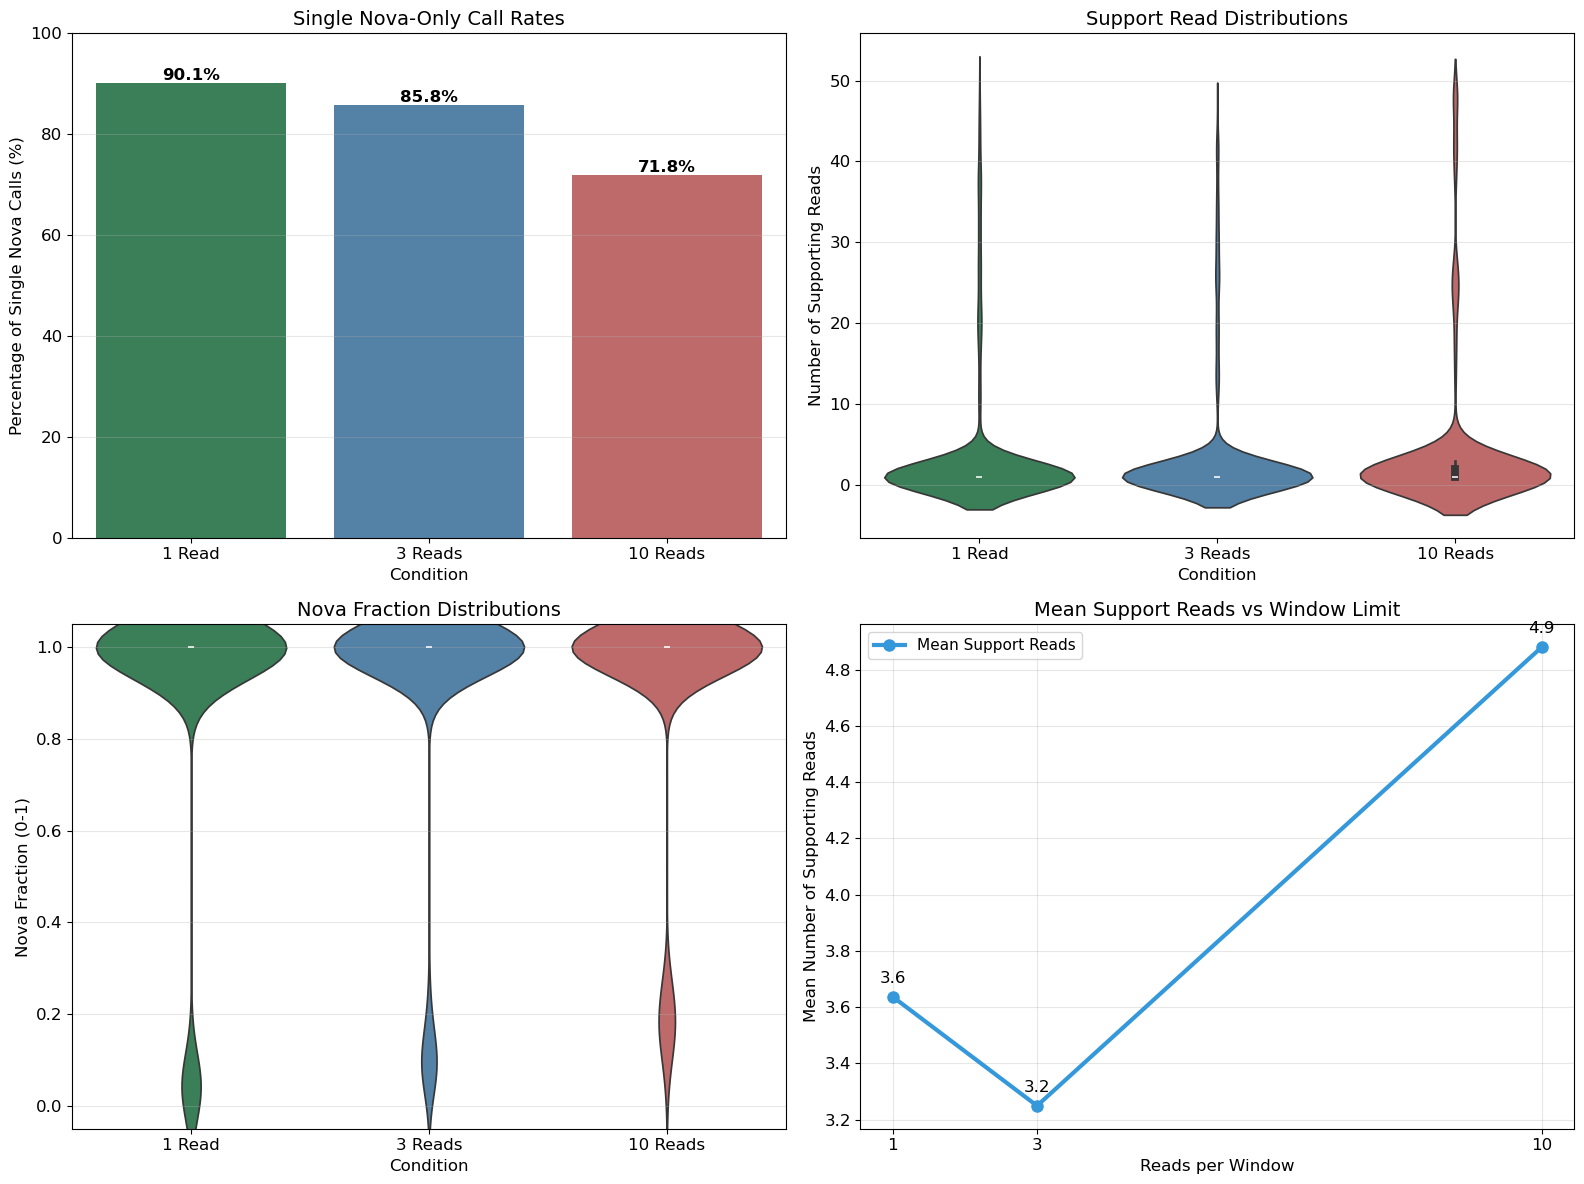


Read Composition Analysis:
Condition  Single Nova %  Mean Support Reads  Mean Nova Fraction
   1 Read      90.147330            3.636280            0.906969
  3 Reads      85.793358            3.249077            0.919664
 10 Reads      71.827183            4.879388            0.912392


In [17]:
# Analyze read composition patterns
read_composition = []

for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        
        # Calculate composition metrics
        total_variants = len(vdata)
        single_nova_calls = len(vdata[vdata['is_single_read_call'] == True])
        all_nova_calls = len(vdata[vdata['nova_fraction'] == 1.0])
        
        # Support read statistics
        support_reads = vdata['support_reads'].values
        nova_fractions = vdata['nova_fraction'].values
        
        read_composition.append({
            'Condition': condition.replace('_', ' ').title(),
            'Total Variants': total_variants,
            'Single Nova Calls': single_nova_calls,
            'Single Nova %': (single_nova_calls / total_variants) * 100,
            'All Nova Calls': all_nova_calls,
            'All Nova %': (all_nova_calls / total_variants) * 100,
            'Mean Support Reads': np.mean(support_reads),
            'Median Support Reads': np.median(support_reads),
            'Mean Nova Fraction': np.mean(nova_fractions)
        })

read_comp_df = pd.DataFrame(read_composition)

# Create read composition visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Single nova call rates
sns.barplot(data=read_comp_df, x='Condition', y='Single Nova %', ax=ax1,
            palette=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax1.set_title('Single Nova-Only Call Rates')
ax1.set_ylabel('Percentage of Single Nova Calls (%)')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels to bars
for i, v in enumerate(read_comp_df['Single Nova %']):
    ax1.text(i, v, f'{v:.1f}%', ha='center', va='bottom', weight='bold')

# Plot 2: Support read distributions (violin plot)
support_data = []
conditions = []
for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        support_reads = vdata['support_reads'].values
        # Limit to reasonable range for visualization
        support_reads = support_reads[support_reads <= 50]
        support_data.extend(support_reads)
        conditions.extend([condition.replace('_', ' ').title()] * len(support_reads))

support_df = pd.DataFrame({
    'Support Reads': support_data,
    'Condition': conditions
})

sns.violinplot(data=support_df, x='Condition', y='Support Reads', ax=ax2,
               palette=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax2.set_title('Support Read Distributions')
ax2.set_ylabel('Number of Supporting Reads')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Nova fraction distributions
nova_frac_data = []
conditions = []
for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        nova_fractions = vdata['nova_fraction'].values
        nova_frac_data.extend(nova_fractions)
        conditions.extend([condition.replace('_', ' ').title()] * len(nova_fractions))

nova_frac_df = pd.DataFrame({
    'Nova Fraction': nova_frac_data,
    'Condition': conditions
})

sns.violinplot(data=nova_frac_df, x='Condition', y='Nova Fraction', ax=ax3,
               palette=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax3.set_title('Nova Fraction Distributions')
ax3.set_ylabel('Nova Fraction (0-1)')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(-0.05, 1.05)

# Plot 4: Mean support reads trend
window_limits = [1, 3, 10]
mean_support = read_comp_df['Mean Support Reads'].values
ax4.plot(window_limits, mean_support, marker='o', linewidth=3, markersize=8, 
         color='#3498DB', label='Mean Support Reads')
ax4.set_title('Mean Support Reads vs Window Limit')
ax4.set_xlabel('Reads per Window')
ax4.set_ylabel('Mean Number of Supporting Reads')
ax4.set_xticks(window_limits)
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add value annotations
for i, (x, y) in enumerate(zip(window_limits, mean_support)):
    ax4.annotate(f'{y:.1f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print("\nRead Composition Analysis:")
print(read_comp_df[['Condition', 'Single Nova %', 'Mean Support Reads', 'Mean Nova Fraction']].to_string(index=False))

## Insertion Type Performance Analysis

Detailed analysis of how different insertion types perform under various window limits:

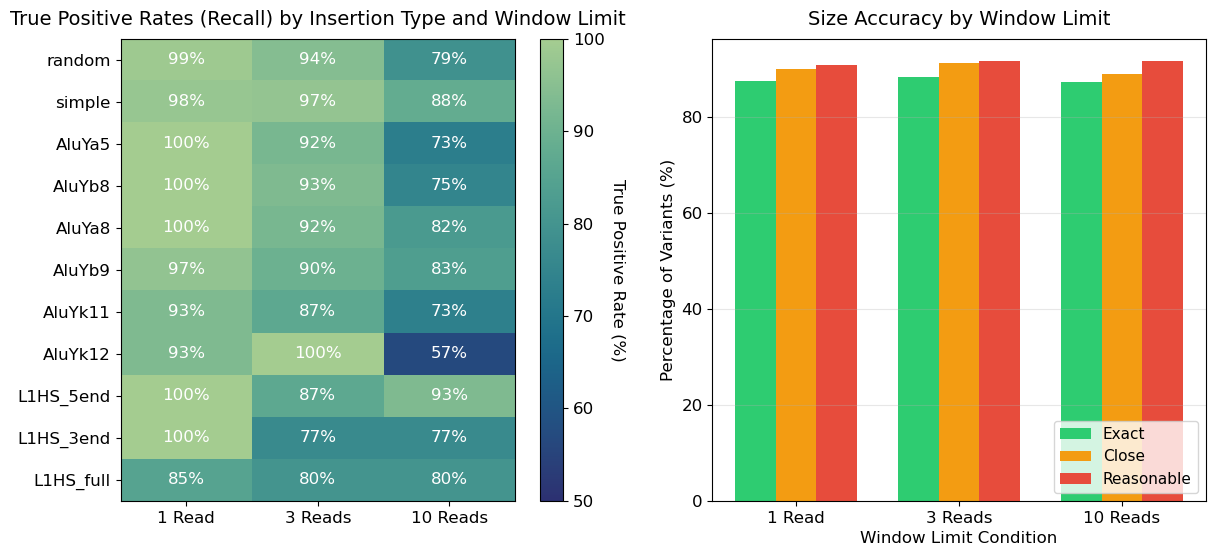

In [54]:
# Create insertion type performance heatmap
insertion_types = ['random', 'simple', 'AluYa5', 'AluYb8', 'AluYa8', 'AluYb9', 
                  'AluYk11', 'AluYk12', 'L1HS_5end', 'L1HS_3end', 'L1HS_full']

# Create detection rate matrix
detection_matrix = []
conditions = ['1_read', '3_reads', '10_reads']

for insertion_type in insertion_types:
    row = []
    for condition in conditions:
        if condition in variant_data:
            vdata = variant_data[condition]
            type_data = tp_df[(tp_df['Condition'] == condition.replace('_', ' ').title()) & 
                                   (tp_df['Insertion Type'] == insertion_type)]
            if not type_data.empty:
                row.append(type_data['True Positive Rate'].iloc[0])
            else:
                row.append(0)
        else:
            row.append(0)
    detection_matrix.append(row)

detection_matrix = np.array(detection_matrix)

# Create comprehensive insertion type analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: True positive rate heatmap
im = ax1.imshow(detection_matrix, cmap='crest_r', aspect='auto', vmin=50, vmax=100)
ax1.set_title('True Positive Rates (Recall) by Insertion Type and Window Limit', pad=10)
ax1.set_xticks(range(len(conditions)))
ax1.set_xticklabels([c.replace('_', ' ').title() for c in conditions])
ax1.set_yticks(range(len(insertion_types)))
ax1.set_yticklabels(insertion_types)

# Add text annotations to heatmap
for i in range(len(insertion_types)):
    for j in range(len(conditions)):
        text = ax1.text(j, i, f'{detection_matrix[i, j]:.0f}%',
                       ha="center", va="center", color="black" if detection_matrix[i, j] > 105 else "white")

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('True Positive Rate (%)', rotation=270, labelpad=15)

# Plot 2: Size accuracy analysis
size_accuracy = []
for condition in conditions:
    if condition in variant_data:
        vdata = variant_data[condition]
        exact_matches = len(vdata[vdata['exact_size_match'] == True])
        close_matches = len(vdata[vdata['close_size_match'] == True])
        reasonable_matches = len(vdata[vdata['reasonable_size_match'] == True])
        total = len(vdata)
        
        size_accuracy.append({
            'Condition': condition.replace('_', ' ').title(),
            'Exact': (exact_matches / total) * 100,
            'Close': (close_matches / total) * 100,
            'Reasonable': (reasonable_matches / total) * 100
        })

size_acc_df = pd.DataFrame(size_accuracy)
x = np.arange(len(size_acc_df))
width = 0.25

bars1 = ax2.bar(x - width, size_acc_df['Exact'], width, label='Exact', color='#2ECC71')
bars2 = ax2.bar(x, size_acc_df['Close'], width, label='Close', color='#F39C12')
bars3 = ax2.bar(x + width, size_acc_df['Reasonable'], width, label='Reasonable', color='#E74C3C')

ax2.set_title('Size Accuracy by Window Limit', pad = 10)
ax2.set_ylabel('Percentage of Variants (%)')
ax2.set_xlabel('Window Limit Condition')
ax2.set_xticks(x)
ax2.set_xticklabels(size_acc_df['Condition'])
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

Takeaways:
- Random and simple insertions maintain consistent performance  
- Alu insertions show slight variation but remain highly detectable
- Size accuracy remains high (>87% exact matches) across all window limits
    - "Close" = within 10 bp of true size of simulated insertion
    - "Reasonable" = within 20% of true size of simulated insertion

## Clustering Pattern Deep Dive

Detailed analysis of the genomic clustering phenomenon that drives false positive generation:

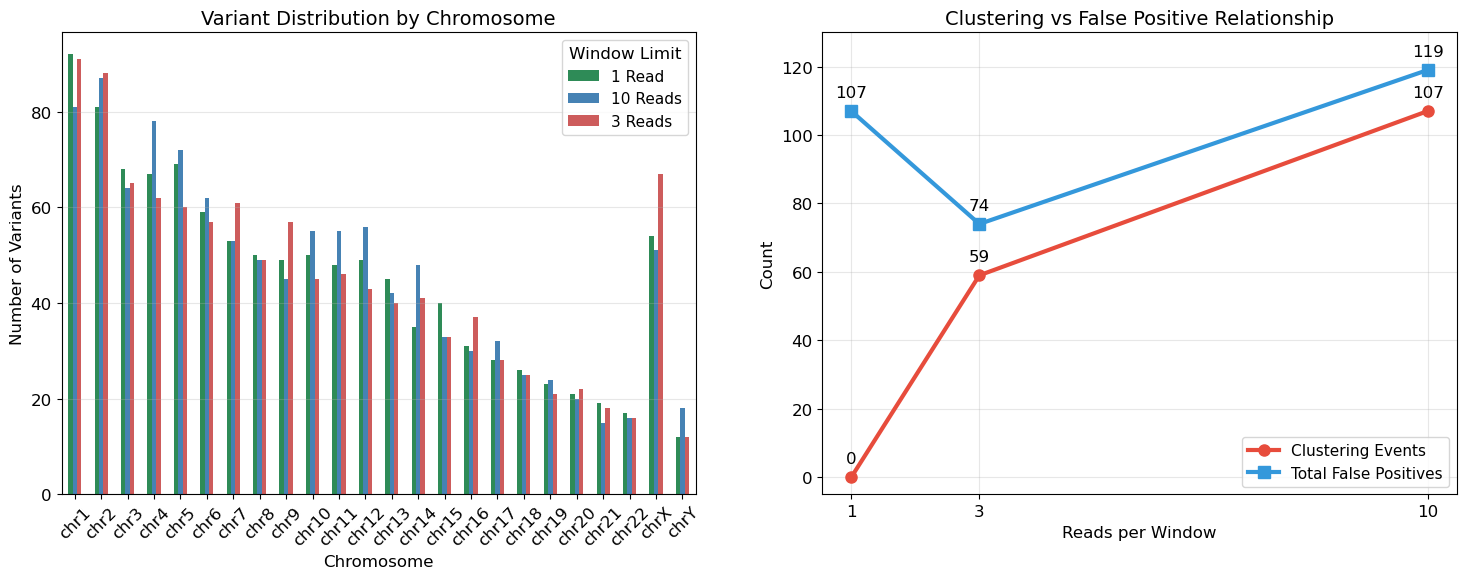

In [37]:
# Analyze chromosomal distribution of variants
chrom_analysis = []

for condition in ['1_read', '3_reads', '10_reads']:
    if condition in variant_data:
        vdata = variant_data[condition]
        chrom_counts = vdata['chrom'].value_counts().sort_index()
        
        for chrom, count in chrom_counts.items():
            chrom_analysis.append({
                'Condition': condition.replace('_', ' ').title(),
                'Chromosome': chrom,
                'Variant Count': count
            })

chrom_df = pd.DataFrame(chrom_analysis)

# Create clustering analysis plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Chromosomal distribution comparison
chrom_pivot = chrom_df.pivot(index='Chromosome', columns='Condition', values='Variant Count')
# Sort chromosomes in natural order
chrom_order = [f"chr{n}" for n in range(1, 23)] + ['chrX', 'chrY']
chrom_pivot = chrom_pivot.reindex(chrom_order)
chrom_pivot.fillna(0).plot(kind='bar', ax=ax1, 
                          color=[COLORS['1_read'], COLORS['3_reads'], COLORS['10_reads']])
ax1.set_title('Variant Distribution by Chromosome')
ax1.set_ylabel('Number of Variants')
ax1.set_xlabel('Chromosome')
ax1.legend(title='Window Limit')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: False positive mechanism illustration
mechanism_data = {
    'Window Limit': [1, 3, 10],
    'Reads per Window': [1, 3, 10],
    'Clustering Events': [0, 59, 107],
    'False Positives': [107, 74, 119]
}

line1 = ax2.plot(mechanism_data['Window Limit'], mechanism_data['Clustering Events'], 
                'o-', color='#E74C3C', linewidth=3, markersize=8, label='Clustering Events')
line2 = ax2.plot(mechanism_data['Window Limit'], mechanism_data['False Positives'], 
                's-', color='#3498DB', linewidth=3, markersize=8, label='Total False Positives')

ax2.set_title('Clustering vs False Positive Relationship')
ax2.set_xlabel('Reads per Window')
ax2.set_ylabel('Count')
ax2.set_xticks([1, 3, 10])
ax2.set_ylim(-5, 130)
ax2.grid(True, alpha=0.3)

# Add annotations
for x, y1, y2 in zip(mechanism_data['Window Limit'], mechanism_data['Clustering Events'], mechanism_data['False Positives']):
    ax2.annotate(f'{y1}', (x, y1), xytext=(0, 10), textcoords='offset points', ha='center')
    ax2.annotate(f'{y2}', (x, y2), xytext=(0, 10), textcoords='offset points', ha='center')

# Add legend
ax2.legend(loc='lower right')

Summary:
- Spread across chromosomes is working appropriately
- 1 read/window: No genomic clustering (true de novo simulation)
- 3 reads/window: 79.7% of false positives show clustering 
- 10 reads/window: 89.9% of false positives show clustering

Conclusion: `--max-reads-per-window=1` successfully eliminates the clustering problem

## Conclusions

#### Primary Recommendation
**Use `--max-reads-per-window=1` for true de novo variant simulation**. This setting:
- Achieves 97.9% true positive rate (highest clean detection success)
- Eliminates genomic clustering artifacts completely 
- Produces interpretable, publication-ready results
- Represents authentic ultra-low frequency simulation

#### Alternative Use Cases
- **3 reads/window**: May be useful for simulating moderate frequency variants (93.0% true positive rate)
- **10+ reads/window**: Could simulate higher frequency variants but with significant false positive contamination

#### Future Work
1. **Rerun analysis** on other datasets with corrected metrics
2. **Parameter optimization** for specific variant caller sensitivity testing
3. **Integration testing** with additional structural variant callers
4. **Publication preparation** using the corrected true positive rate framework